<center>
<h1>COMP4680/8650: Advanced Topics in Machine Learning</h1>
<h2>Assignment #6: Deep Learning Programming Assignment</h2>
Semester 2, 2022<br>
</center>
    
**Due**: 11:55pm on Sunday 30 October, 2022.<br>
Submit as a single Jupyter Notebook via Wattle. Make sure that your name and student ID appears in the section below. Cite all sources of help used outside of the PyTorch documentation.

---

**Name:** Hengcheng Zhang
<br>
**Student ID:** u7096187

---

In this assignment you will 
experiment with different optimisation algorithms on a (nonconvex) toy problem and
build a simple neural network for image super resolution using a coordinate-based model.
We will provide you with starter code using the PyTorch deep learning
library, which can be downloaded from https://pytorch.org/. Follow the installation instructions (for
the stable release, v1.12.1 at time of writing), being sure to install both `pytorch` and `torchvision`.
On Windows you may need to install the `Microsoft Visual C++ Redistributable` (you will get an error
with URL on where to find the release if not installed when you run the code below).
Browse through some of the PyTorch user documentation and tutorials.


**Run all code blocks from start to end (`Restart & Run All`) and then save your Jupyter Notebook
before submitting your assignment to ensure everything works as expected.**

In [3]:
# %matplotlib ipympl
%matplotlib widget

import numpy as np
import numpy.random as rnd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# 1. From Convex Optimisation to Non-Convex Optimisation (40 marks)

So far we have learned tools for convex optimisation. However deep learning is usually non-convex. While there are specialised methods for solving non-convex problems, for example alternating minimisation methods or branch-and-bound methods, many of them build on ideas from convex optimisation. Very few non-convex optimisation problems can be truly solved and we have to be content with a local minimum.

In this question we will investigate different optimisation algorithms (often called optimizers in machine learning software packages). As an example we use the famous non-convex test problem called the six-hump camel function [Dizon and Szegö, 1978](https://www.sfu.ca/~ssurjano/camel6.html), defined as

$$
f(x_1, x_2)=\left( 4-2.1x_1^2+\frac{x_1^4}{3}\right)x_1^2 +x_1x_2 + (-4+4x_2^2)x_2^2.
$$

It has six local minima, two of which are global.

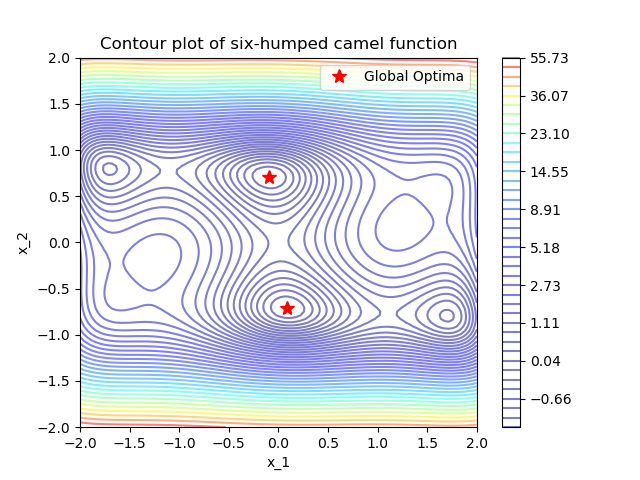

In [3]:
def six_humped_camel(x1, x2):
    # x1 and x2 are tensors of the same shape. Returns y of the same shape
    y = (4 - 2.1 * x1**2 + x1**4 / 3) * x1**2 + \
        x1 * x2 + (-4 + 4 * x2**2) * x2**2
    return y

global_minima = np.array([[-0.0898,0.7126],[0.0898,-0.7126]])
domain = np.linspace(-2,2,100)
x_grid,y_grid = np.meshgrid(domain, domain)
z_grid = six_humped_camel(x_grid, y_grid)

fig, ax = plt.subplots()
offset = 1 - z_grid.min()
levels = np.exp(np.linspace(0, (np.log(z_grid.max()+offset)), 40))-offset
cm=ax.contour(x_grid, y_grid, z_grid, levels=levels, cmap=plt.cm.jet, alpha=0.5)
plt.colorbar(cm)
ax.set_xlabel('x_1'); ax.set_ylabel('x_2')
ax.plot(global_minima[:,0], global_minima[:,1], 'r*', markersize=10, label="Global Optima")
plt.legend()
plt.title('Contour plot of six-humped camel function')
plt.show()

In machine learning problems, the non-convex parameter landscape is a function of the data and a non-convex model and/or loss, which usually decomposes over each data instance. For given data set ${\cal D} = \{D_1, \ldots, D_N\}$ and model parameters $\mathbf{x}$ we can summarise this mathematically as

$$
\mathcal{L}(\mathbf{x}; \mathcal{D}) = \frac{1}{N} \sum_{i=1}^{N} f(\mathbf{x}, D_i)
$$

where $f$ is the per-instance loss and the parameter landscape is the plot of the loss $\mathcal{L}$ against parameters $\mathbf{x}$. Here the optimisation problem is to find a value for $\mathbf{x}$ where $\mathcal{L}(\mathbf{x}; {\cal D})$ is minimal (or at least low).

To make this toy problem more like such a problem, we will actually optimise the following loss

$$
\mathcal{L}(\mathbf{x}; \mathcal{D}) =  \frac{1}{N} \sum_{i=1}^{N} f(\mathbf{x}, D_i) =  \frac{1}{N} \sum_{i=1}^{N} \left( a_i+b_ix_1^2+c_ix_1^4\right)x_1^2 +d_ix_1x_2 + (e_i+f_ix_2^2)x_2^2.
$$
where $D_i=(a_i, b_i, c_i, d_i, e_i, f_i)$ is the input data and $\mathbf{x}=(x_1, x_2)$ are the parameters of the model. We will generate our data as

$$
D_i \sim \mathcal{N}\left((4, -2.1, \frac{1}{3}, 1, -4, 4), \sigma I\right)
$$
so that each instance is a perturbed six-humped camel function and optimising the expected loss over (infinite) data is equivalent to optimising for a six-humped camel function.

The following plots show that the expected loss over the whole dataset is very similar to the ground truth six-humped camel function, while the expected loss over the first 10 instances looks somewhat different.


In [4]:
# Make the data and define the loss function
np.random.seed(1)
mean_data = np.array([4.0,-2.1,1/3,1,-4,4])
data = torch.tensor(np.random.randn(500,6) + mean_data) # (500,6)

def loss(data, x):
    # Given data of shape (N, 6) and x of shape (2,), computes loss for each instance of shape (N,)
    assert len(data.shape) == 2 and data.shape[1]==6, data.shape
    assert x.shape == (2,), x.shape
    return (data[:,0] + data[:,1] * x[0]**2 + data[:,2]*x[0]**4) * x[0]**2 + \
        data[:,3]*x[0] * x[1] + (data[:,4] + data[:,5] * x[1]**2) * x[1]**2

In [ ]:
loss_data = torch.randn(1,6)
x =torch.randn(2,)
loss(loss_data,x).item()

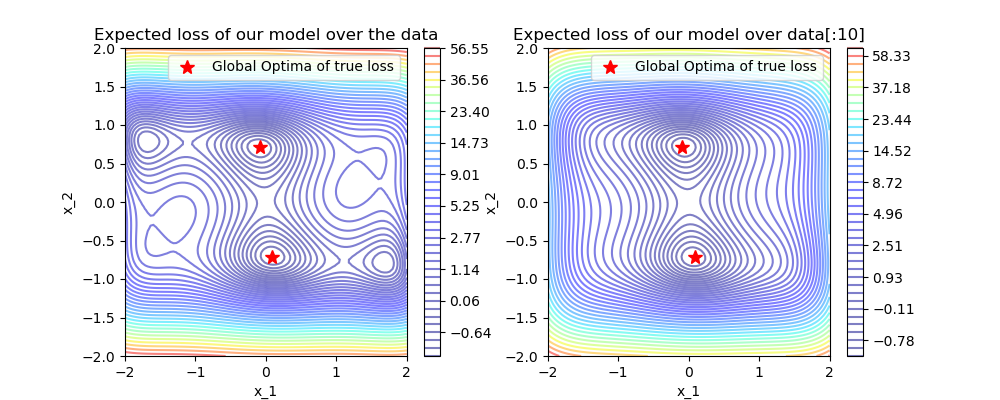

In [5]:
grid_vals = torch.tensor(np.stack([x_grid.reshape(-1), y_grid.reshape(-1)], axis=-1)) # (10000,2)

fig2, axs = plt.subplots(1, 2, figsize=(10,4))
z_grid_2 = torch.stack([loss(data, xy).mean() for xy in grid_vals], dim=-1).reshape(100,100).numpy()
offset = 1 - z_grid_2.min()
levels = np.exp(np.linspace(0, (np.log(z_grid_2.max()+offset)), 40))-offset
cm=axs[0].contour(x_grid, y_grid, z_grid_2, levels=levels, cmap=plt.cm.jet, alpha=0.5)
plt.colorbar(cm, ax=axs[0])
axs[0].set_xlabel('x_1'); axs[0].set_ylabel('x_2')
axs[0].plot(global_minima[:,0], global_minima[:,1], 'r*', markersize=10, label="Global Optima of true loss")
axs[0].legend()
axs[0].set_title('Expected loss of our model over the data')

z_grid_2 = torch.stack([loss(data[:10], xy).mean() for xy in grid_vals], dim=-1).reshape(100,100).numpy()
offset = 1 - z_grid_2.min()
levels = np.exp(np.linspace(0, (np.log(z_grid_2.max()+offset)), 40))-offset
cm=axs[1].contour(x_grid, y_grid, z_grid_2, levels=levels, cmap=plt.cm.jet, alpha=0.5)
plt.colorbar(cm, ax=axs[1])
axs[1].set_xlabel('x_1'); axs[1].set_ylabel('x_2')
axs[1].plot(global_minima[:,0], global_minima[:,1], 'r*', markersize=10, label="Global Optima of true loss")
axs[1].legend()
axs[1].set_title('Expected loss of our model over data[:10]')
plt.show()

### Gradient descent optimisation algorithms

We will now compare multiple optimisation algorithms on this problem.

- The first algorithm we will compare is __batch gradient descent (GD)__. As per the Wk 10 slides, the update is
$$ 
x \leftarrow x -\eta \nabla_x \mathcal{L}
$$
where $\eta$ is the learning rate.


- The second algorithm we will compare to is __stochastic gradient descent (SGD)__. As per the Wk 10 slides, rather than using the whole gradient we only compute the gradient on a subset of the data, sometimes called a mini-batch, and do the descent using that gradient. On expectation the gradient will approximate the full gradient, so this method should also converge to a local minima of the expected loss of the whole dataset.


- The third algorithm we will compare to is __SGD with momentum__. The idea behind momentum is to reduce noise in the stochastic estimation of the gradient by computing a weighted sum of previous gradient directions. The update rule is
\begin{align}
v &\leftarrow \gamma v + \nabla_x \mathcal{L}\\
x &\leftarrow x - \eta v
\end{align}
where $v$ is the momentum, $\gamma$ controls the weighting of previous gradients, and initially $v = \nabla_x \mathcal{L}$.


- The fourth and fifth algorithms we will compare to are __AdaGrad and Adam__, which are covered in the Wk 10 slides.

You will implement GD, SGD and SGD with momentum (a simplified version of PyTorch's implementation) and use PyTorch's implementation of AdaGrad and Adam. The first three are condensed into an optimisation class, called `CustomSGDwMomentum(params, lr, momentum)`, which takes a list of parameters, a learning rate and a momentum value. You will also complete the implementation of function `train_model(data, x, optimizer, bs, max_epochs)` which trains the parameter $x$ using the given optimizer and batch size `bs` until convergence (or until `max_epochs` has been reached). 

Note that GD is then implemented by having `momentum=0` and `bs` equal to the full dataset size, SGD is implemented by `momentum=0` and `bs` equal to something less than the full dataset size, and SGD with momentum is the same with non-zero momentum.

## 1.1 Implement `CustomSGDwMomentum` and `train_model` (20 marks)

Complete each `TODO` section and do not modify any other code. If you are unable to implement `CustomSGDwMomentum` then the testing code will revert to using PyTorch's SGD optimizer.

In [6]:
class CustomSGDwMomentum(torch.optim.Optimizer):

    def __init__(self, params, lr, momentum=0):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))

        defaults = dict(lr=lr, momentum=momentum)
        super(CustomSGDwMomentum, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure : An optional feature for PyTorch optimizers, we will not be using it here.
        """

        # for each different group of parameters that we specify
        for group in self.param_groups:
            params_with_grad = []
            grad_list = []
            v_list = []
            momentum_gamma = group['momentum']
            lr = group['lr']

            # populate the list of params, grads and vs (momentums)
            for p in group['params']:
                if p.grad is not None:
                    # add parameter to list of parameters to update
                    params_with_grad.append(p)
                    # add grad saved in that parameter to list
                    grad_list.append(p.grad)

                    # add momentum we have saved in that parameter's state to list
                    if 'v' not in self.state[p]:
                        v_list.append(torch.clone(p.grad).detach())
                    else:
                        v_list.append(self.state[p]['v'])

            # update each param in params_with_grad with their respect grad in grad_list and
            # momentum term in v_list
            for i in range(len(params_with_grad)):

                ##############################################################################
                # TODO: Implement the update rule (update v_list and params_with_grad).      #
                # Make sure to update the parameters in params_with_grad inplace, i.e. do    #
                # not replace them with a new tensor. One way to do this is to do            #
                # `param += val`, note that `param = param + val` creates a new variable (or #
                # in PyTorch a new tensor that is not an nn.Parameter) and assigns it to     #
                # the variable named param.                                                  #

                # if i == len(params_with_grad) - 1:
                # pass
                temp = grad_list[i]
                vi = v_list[i]
                temp += momentum_gamma * vi
                # v_list[i+1] = momentum_gamma * v_list[i] + grad_list[i]
                # params_with_grad[i] += - lr * v_list[i+1]
                params_with_grad[i] += - lr * temp

                ##############################################################################
                # raise NotImplementedError

            # Update momentum v in each param's state
            for p, v in zip(params_with_grad, v_list):
                self.state[p]['v'] = v

        return loss


In [9]:
def train_model(data, x, optimizer, bs, max_epochs):
    # x_vals_SGD, loss_vals_SGD = train_model(data, x, optimizer, bs=30, max_epochs=1000)
    """
    Trains model with given parameters and optimizer until convergence unless it had reached max_epochs 
        data is of shape (N, D)
        x is the parameters (P,)
        optimizer is an initialised pytorch optimizer with parameters [x,]
        bs is the batch size, None means the full dataset size
        max_epochs is the maximum number of epochs to run for.
    """

    x_vals = []
    loss_vals = []
    x_vals.append(np.copy(x.detach().numpy()))

    N, _ = data.shape
    # N = 500
    if bs == None:
        bs = N
    batches_per_epoch = int(np.ceil(N/bs))
    # 500/30
    assert 1 <= bs <= N

    for epoch in range(max_epochs):
        for i in range(batches_per_epoch):

            #######################################################################################
            # TODO: Get the mean loss over the i^th mini-batch of size bs, and take a step on x.  #
            # Have a look at the PyTorch documentation. You will need to:                         #
            #   1. zero the gradient by calling `zero_grad()` on the optimiser                    #
            #   2. compute the mean loss of the current mini-batch and call it `loss_val`         #
            #   3. compute the gradient for the loss by running `backward()`                      #
            #   4. take a gradient step by calling `step()` on the optimiser                      #

            optimizer.zero_grad()

            start_index = i * batches_per_epoch

            # loss_val = torch.tensor(torch.mean(loss(data[start_index:start_index +
            #                 batches_per_epoch, ], x)),requires_grad=True)
            loss_val = torch.mean(loss(data[start_index:start_index +
                            batches_per_epoch, ], x))

            loss_val.backward()

            optimizer.step()

            #######################################################################################

            # raise NotImplementedError

            # store loss of each iteration
            loss_vals.append(loss_val.item())
            current_x = np.copy(x.detach().numpy())

        # determine if converged by whether the parameters haven't changed
        if np.linalg.norm(current_x - x_vals[-1]) < 1e-4:
            break
        # store parameter value at the end of the epoch
        x_vals.append(current_x)

    x_vals = np.stack(x_vals, axis=0)
    print("Finished after {} epochs".format(x_vals.shape[0]))
    return x_vals, loss_vals


Run the following code to optimise the loss function using different optimisers. It will fail if you have not yet completed implementation of the functions above, in particular, the `train_model` function.

In [10]:
# Train with different optimisers starting at x = [1.5, 1.5]

### GD
x = nn.Parameter(torch.tensor([1.5, 1.5]))
try:
    optimizer = CustomSGDwMomentum([x], lr=0.001)
    x_vals_GD, loss_vals_GD = train_model(data, x, optimizer, bs=None, max_epochs=1000)
except NotImplementedError:
    # fallback if you haven't been able to implement CustomSGDwMomentum
    optimizer = torch.optim.SGD([x], lr=0.001)
    x_vals_GD, loss_vals_GD = train_model(data, x, optimizer, bs=None, max_epochs=1000)
    
### SGD
x = nn.Parameter(torch.tensor([1.5, 1.5]))
try:
    optimizer = CustomSGDwMomentum([x], lr=0.001)
    x_vals_SGD, loss_vals_SGD = train_model(data, x, optimizer, bs=30, max_epochs=1000)
except NotImplementedError:
    # fallback if you haven't been able to implement CustomSGDwMomentum
    optimizer = torch.optim.SGD([x], lr=0.001)
    x_vals_SGD, loss_vals_SGD = train_model(data, x, optimizer, bs=30, max_epochs=1000)

### SGD with momentum
x = nn.Parameter(torch.tensor([1.5, 1.5]))
try:
    optimizer = CustomSGDwMomentum([x], lr=0.001, momentum=0.9)
    x_vals_SGDm, loss_vals_SGDm = train_model(data, x, optimizer, bs=30, max_epochs=1000)
except NotImplementedError:
    optimizer = torch.optim.SGD([x], lr=0.001, momentum=0.9) # Use this is you haven't been able to implement CustomSGDwMomentum
    x_vals_SGDm, loss_vals_SGDm = train_model(data, x, optimizer, bs=30, max_epochs=1000)

### AdaGrad
x = nn.Parameter(torch.tensor([1.5, 1.5]))
optimizer = torch.optim.Adagrad([x], lr=0.1)
x_vals_AG, loss_vals_AG = train_model(data, x, optimizer, bs=30, max_epochs=1000)

### Adam
x = nn.Parameter(torch.tensor([1.5, 1.5]))
optimizer = torch.optim.Adam([x], lr=0.1)
x_vals_Adam, loss_vals_Adam = train_model(data, x, optimizer, bs=30, max_epochs=1000)

/Users/x_x/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in subtract


Finished after 1001 epochs
Finished after 52 epochs
Finished after 27 epochs
Finished after 106 epochs
Finished after 82 epochs


Once your optimisers have run to completion, execute the following code to visualise the optimisation path.

In [ ]:
# Plot animation of the training
from matplotlib import animation
fig, ax = plt.subplots()
offset = 1 - z_grid.min()
levels = np.exp(np.linspace(0, (np.log(z_grid.max()+offset)), 40))-offset
cm=ax.contour(x_grid, y_grid, z_grid, levels=levels, cmap=plt.cm.jet, alpha=0.5)
plt.colorbar(cm)
ax.set_xlabel('x_1'); ax.set_ylabel('x_2')
ax.plot(global_minima[:,0], global_minima[:,1], 'r*', markersize=10, label="Global Optima")
lineGD, = ax.plot(x_vals_GD[:0,0], x_vals_GD[:0,1], 'b.-', markersize=5, label="GD, {} epochs".format(x_vals_GD.shape[0]))
lineSGD, = ax.plot(x_vals_SGD[:0,0], x_vals_SGD[:0,1], 'g.-', markersize=5, label="SGD, {} epochs".format(x_vals_SGD.shape[0]))
lineSGDm, = ax.plot(x_vals_SGDm[:0,0], x_vals_SGDm[:0,1], 'c.-', markersize=5, label="SGD with momentum, {} epochs".format(x_vals_SGDm.shape[0]))
lineAG, = ax.plot(x_vals_AG[:0,0], x_vals_AG[:0,1], 'm.-', markersize=5, label="Adagrad, {} epochs".format(x_vals_AG.shape[0]))
lineAdam, = ax.plot(x_vals_Adam[:0,0], x_vals_Adam[:0,1], 'k.-', markersize=5, label="Adam, {} epochs".format(x_vals_Adam.shape[0]))
plt.legend()
plt.title('Contour plot of six-humped camel function')

def init():
    lineGD.set_data(x_vals_GD[:0,0], x_vals_GD[:0,1])
    lineSGD.set_data(x_vals_SGD[:0,0], x_vals_SGD[:0,1])
    lineSGDm.set_data(x_vals_SGDm[:0,0], x_vals_SGDm[:0,1])
    lineAG.set_data(x_vals_AG[:0,0], x_vals_AG[:0,1])
    lineAdam.set_data(x_vals_Adam[:0,0], x_vals_Adam[:0,1])

def animate(i):
    lineGD.set_data(x_vals_GD[:i,0], x_vals_GD[:i,1])
    lineSGD.set_data(x_vals_SGD[:i,0], x_vals_SGD[:i,1])
    lineSGDm.set_data(x_vals_SGDm[:i,0], x_vals_SGDm[:i,1])
    lineAG.set_data(x_vals_AG[:i,0], x_vals_AG[:i,1])
    lineAdam.set_data(x_vals_Adam[:i,0], x_vals_Adam[:i,1])

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)

plt.show()

## 1.2. Answer the following questions. Feel free to use other sources, but cite them (no style necessary, just website link etc. is enough). (10 marks)

### 1.2.1: Why is SGD used instead of batch gradient descent? Give 2 reasons.

*(enter your answer here)*

### 1.2.2: Summarise the advantages of SGD with momentum, Adagrad and Adam over vanilla SGD.

*(enter your answer here)*

### 1.2.3: Gradient descent as taught in lecture 7 has a line search component. Why is line search typically not used in deep learning? We also covered a second order method, Newton's method, in lecture 7. Why are second order methods impractical for deep learning use cases, which typically have high-dimensional datasets?

*(enter your answer here)*

## 1.3. Experiment with the different optimisers with different batch sizes and starting points. Comment on how this affects the minima at which the optimsation converges at (if it converges at all), espcially whether it was able to escape close local minima and reach better minima, and why this is the case. (10 marks)

To do this, you can just call the training code above in a new cell, i.e.,
```
x = nn.Parameter(torch.tensor([1.5, 1.5]))                                            # Change starting point here
optimizer = CustomSGDwMomentum([x], lr=0.001, momentum=0.9)                           # Change optimiser here
x_vals_SGDm, loss_vals_SGDm = train_model(data, x, optimizer, bs=30, max_epochs=1000) # Change batch-size here
```

You can then copy, paste and run the plotting code in a new cell.


*(enter your answer here)*

# 2. Coordinate-Based Networks (60 marks)

Your task is to implement an coordinate-based network for image super resolution. Unlike standard machine learning models for computer vision where we learn over a training set of images with the goal of generialising to new images, here we optimise a single model per image with the goal of interpolating between observed pixels. Given a $W$-by-$H$ input image our goal is to learn a nerual network that maps from normalised coordinates $(u, v) \in [0, 1] \times [0, 1]$ to the RGB value of the pixel at that coordinate. We do this by performing stochastic gradient descent on the following objective,

$$
\begin{align}
\mathcal{L}(\theta; \mathcal{I}) &= \sum_{(u, v)} \| f_\theta(u, v) - \mathcal{I}(u, v) \|
\end{align}
$$

where $\mathcal{I}$ is the image and $f_\theta : \mathbb{R}^2 \to \mathbb{R}^3$ is a neural network with parameters $\theta$. During training we sample $(u, v)$ from the normalised pixel space. Once trained, we can produce a high-resolution output image by sampling $(u, v)$ at arbitrary precision.

We will implement the coordinate-based network as a multi-layer perceptron (MLP). However, instead of providing raw pixel coordinates $x = (u, v)$ as input to the MLP we will first apply random frequency feature mappings, which have been shown to be effective for image reconstruction [Tanik et al., NeurIPS 2020](https://arxiv.org/abs/2006.10739). Specifically, let $B$ be a fixed 2-by-N matrix with entries sampled i.i.d. from a Gaussian ${\cal N}(0, \sigma^2)$. Then we compute the output colour as

$$
\begin{align}
y = f_\theta(x) = \text{MLP}_\theta(\sin(2\pi B x), \cos(2\pi B x))
\end{align}
$$

We have provided model templates below. The MLP consists of repeated linear, leaky ReLU and batch normalisation layers. **Complete each `TODO` section and do not modify any other code.**

## 2a. The Coordinate-Based Network (30 marks)

In [109]:
###########################################################################
# TODO: Complete the ImageCBN module.                                     #
###########################################################################

class ImageCBN(nn.Module):
    """Model to map from normalised pixel coordinates to a normalised RGB
    colour vector."""

    def __init__(self, hidden_list=(64,), freqs=64):
        """
        Arguments:
        ----------
        hidden_list: iteratable
            List of sizes for each hidden layer

        Returns:
        --------
        None
        """
        super(ImageCBN, self).__init__()

        self.layers = None
        self.B = 10.0 * torch.randn((2, freqs))

        ####################################################################
        # TODO: Create a nn.Sequential model with layers consisting of
        # (fully connected) linear followed by leaky ReLU and batch norm
        # (1d version).
        # The first linear layers input size is defined by the number of
        # frequency features. Remember this includes both sin and cos.
        # Subsequent linear layers have input size defined by hidden_list.
        # The final linear layer should have output size 3. After the output
        # use Sigmoid activation to keep the result between 0 and 1.
        # Assign your nn.Sequence model to the variable self.layers.

        net = nn.Sequential()
        # net.append(nn.Flatten())
        net.append(nn.Linear(freqs * 2, hidden_list[0]))
        net.append(nn.LeakyReLU())
        net.append(nn.BatchNorm1d(hidden_list[0]))
        for i in range(1, len(hidden_list)):
            net.append(nn.Linear(hidden_list[i-1], hidden_list[i]))
            net.append(nn.LeakyReLU())
            net.append(nn.BatchNorm1d(hidden_list[i]))
        net.append(nn.Linear(hidden_list[-1], 3))
        net.append(nn.Sigmoid())
        self.layers = net

        # ref: https://stackoverflow.com/questions/71045286/in-layers-appendnn-batchnorm1dout-feat-0-8-and-layers-appendnn-leakyrelu0
        ####################################################################
        pass

    def forward(self, x):
        """
        Arguments:
        ----------
        x: torch.Tensor
            Input image coordinates of size (B, 2)

        Returns:
        --------
        rgb: torch.Tensor
            Output coordinate colour (B, 3)
        """

        ####################################################################
        # TODO: Implement the foward pass for the coordinate-based network.#
        # input x = (4096, 2) freqs = 256
        # B = (2, freqs)
        # first layer's input is 2 * freqs output is 3
        fourier_feature = torch.matmul(x, self.B)
        x1 = (2 * torch.pi * fourier_feature).cos_()
        x2 = (2 * torch.pi * fourier_feature).sin_()
        x = torch.cat((x1, x2),-1)
        for i, hidden_layer in enumerate(self.layers[:-1]):
            # print(i, hidden_layer)
            x = hidden_layer(x)
        rgb = self.layers[-1](x)

        ####################################################################

        return rgb


In [107]:
# DO NOT MODIFY ANYTHING IN THIS BLOCK

import unittest

# test encoder
class TestCBN(unittest.TestCase):

    def test_size(self):
        """Test that ImageCBN produces the right size model."""
        hidden_sizes = (64, 64)
        freq_size = 128

        model = ImageCBN(hidden_sizes, freq_size)
        self.assertEqual(model.B.size(), torch.Size([2, 128]))
        
        expected_input_sizes = [2 * freq_size] + list(hidden_sizes)
        expected_output_sizes = list(hidden_sizes) + [3]
        linear_layer_index = 0
        for layer in model.layers:
            if isinstance(layer, nn.Linear):
                self.assertLess(linear_layer_index, len(expected_input_sizes))
                self.assertEqual(layer.in_features, expected_input_sizes[linear_layer_index])
                self.assertEqual(layer.out_features, expected_output_sizes[linear_layer_index])
                linear_layer_index += 1
        
# run tests
unittest.main(argv=['first-arg-is-ignored'], exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.011s

OK


# 2b. Coordinate-Based Network Optimisation (30 marks)

The code will run on a GPU if one is available and the appropriate cuda libraries are installed. Otherwise it will run on the CPU (and take longer for training, but should be less than 10 mins). **Make sure your code passes the unit tests above before running any of these experiments.**

After running the training code answer the questions below.

/Users/x_x/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Keeping models on CPU.
Started training at Wed Oct 26 22:04:20 2022
Finished training at Wed Oct 26 22:05:33 2022


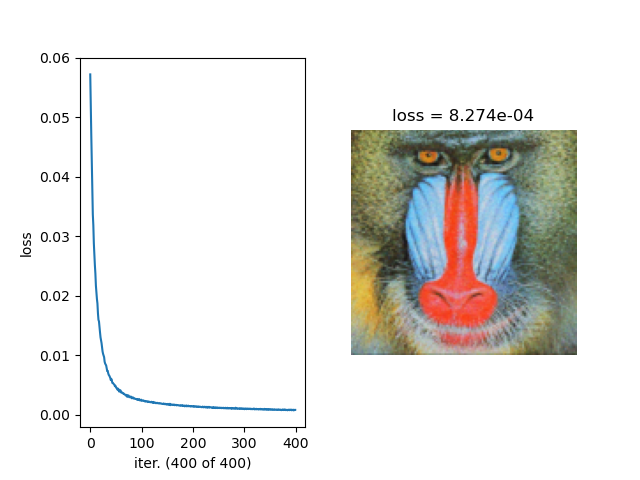

In [122]:
import os
import time

from PIL import Image
import torchvision

# Run on GPU if available. Set to False if you want to force the models
# to stay on the CPU even if cuda is available.
try:
    RUN_ON_GPU = torch.cuda.is_available()
except:
    RUN_ON_GPU = False
    
# Set the random seed for reproducibility
SEED = 4680

np.random.seed(SEED)
torch.manual_seed(SEED)
if RUN_ON_GPU:
    torch.cuda.manual_seed(SEED)


def np_to_var(x):
    """Converts numpy to variable."""
    if RUN_ON_GPU:
        x = x.cuda()
    return Variable(x)


def var_to_np(x):
    """Converts variable to numpy."""
    if RUN_ON_GPU:
        x = x.cpu()
    return x.data.numpy()


def get_data_loader(img_filename, batch_size=32):
    """Creates training data loader."""
    
    img = Image.open(img_filename).convert('RGB')
    rgb = torchvision.transforms.functional.to_tensor(img)
    rgb[rgb > 1.0] = 1.0
    rgb[rgb < 0.0] = 0.0

    x = torch.cartesian_prod(torch.linspace(0, 1, steps=rgb.shape[1]),
                             torch.linspace(0, 1, steps=rgb.shape[2]))
    
    dataset = TensorDataset(x, rgb.view(3, -1).permute([1, 0]))    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


# --- training code -------------------------------------------------------

def create_model(hidden_list=(64,), freqs=0):
    """Creates the coordinate-based network model and moves to the GPU if requested."""

    model = ImageCBN(hidden_list, freqs)

    if RUN_ON_GPU:
        print('Moving models to GPU.')
        model.cuda()
    else:
        print('Keeping models on CPU.')

    return model


def reconstruct_image(model, width=64, height=64, viewport=(0, 1, 0, 1)):
    """Reconstruct an image from the coordinate-based network model."""

    with torch.no_grad():
        x = torch.cartesian_prod(torch.linspace(viewport[2], viewport[3], steps=height),
                                 torch.linspace(viewport[0], viewport[1], steps=width))
    
        rgb = model.forward(x)
        img = rgb.reshape((width, height, 3))
    return img.detach()
    

def train_model(model, img_filename, batch_size=256, num_epochs=50, log_interval=10, plot_fcn=None):
    """Train model."""

    # create optimizer
    objective = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)

    dataloader = get_data_loader(img_filename, batch_size=batch_size)
    total_train_iters = num_epochs * len(dataloader)

    loss_history = []
    print('Started training at {}'.format(time.asctime(time.localtime(time.time()))))

    # train for num_epochs
    for epoch in range(num_epochs):
        for iteration, batch in enumerate(dataloader, epoch * len(dataloader) + 1):

            coords, rgb = batch
            
            # forward pass
            rgb_hat = model(coords)
                        
            # backward pass
            optimizer.zero_grad(set_to_none=True)
            loss = objective(rgb_hat, rgb)
            loss.backward()
            optimizer.step()

            # keep track of loss for plotting or printing
            loss_history.append(loss.data.item())

            # print the log info
            if iteration % log_interval == 0:
                if plot_fcn is None:
                    print('Iteration [{:6d}/{:6d}] | loss: {:.4f}'.format(
                        iteration, total_train_iters, loss_history[-1]))
                else:
                    model.eval()
                    img = reconstruct_image(model, 128, 128)
                    model.train()
                    plot_fcn(loss_history, img, total_train_iters)
                                
    print('Finished training at {}'.format(time.asctime(time.localtime(time.time()))))                
    return loss_history
                
# --- main ----------------------------------------------------------------

fig, ax = plt.subplots(1,2)

def plot_loss(loss, img, x_max=None):
    """Loss plotting."""
    ax[0].clear()
    ax[0].plot(loss)
    if x_max is not None:
        ax[0].set_xlabel('iter. ({} of {})'.format(len(loss), x_max))
    else:
        ax[0].set_xlabel('iter.')
    ax[0].set_ylabel('loss')
    
    ax[1].imshow(img)
    ax[1].axis('off')
    ax[1].set_title('loss = {:0.3e}'.format(loss[-1]))
    fig.canvas.draw()


model = create_model((64, 64), 256)

img_filename = 'mandril.png'
# img_filename = 'bqb.png'
# img_filename = 'passport.PNG'

loss_curve = train_model(model, img_filename, batch_size=4096, num_epochs=100, log_interval=10, plot_fcn=plot_loss)

We can now evaluate the model on any viewport and any scale. For example, the code below zooms in around the right eye.

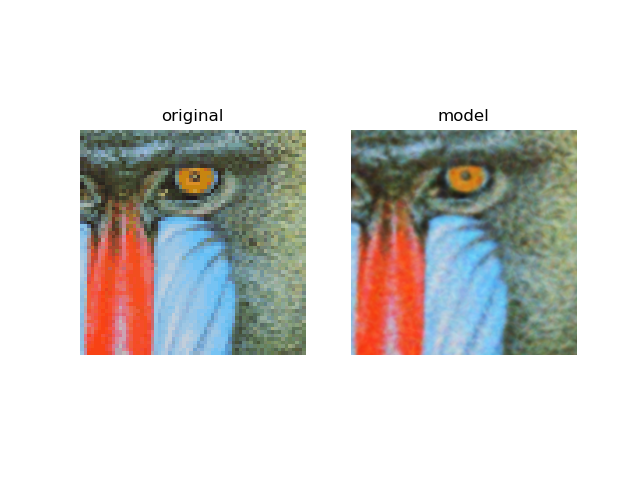

In [123]:
from matplotlib.image import imread
img = imread(img_filename)

model.eval()
img1024x1024 = reconstruct_image(model, 1024, 1024, viewport=[0.4, 0.9, 0.0, 0.5])

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img[0:64, 51:115, :])
plt.axis('off'); plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(img1024x1024)
plt.axis('off'); plt.title('model')
plt.show()


## Questions

**(a)** Calculate the number of learnable parameters in the model. Comment on this number versus the number of pixels in the original image. __(5 marks)__

**(b)** What can you say about the reconstructed image? What about the zoomed in image? __(5 marks)__

**(c)** Comment on what happens when you remove the frequency features and simply reconstruct the image based on raw pixel coordinates, i.e., $y = \text{MLP}_\theta(x)$. __(10 marks)__

**(d)** Experiment with different model configurations and different learning parameters. Can you find a better model or method of training. Include your modified code in a new cell below and justify your reasoning. __(10 marks)__

*(TODO: enter your answer here)*

In [121]:
## TODO: Implement code for part (d).
